# Internship Compensation Intelligence Analysis

## Objective
To benchmark U.S. data-related internship compensation trends and evaluate the impact of geography, role type, company rating, and remote status on salary variation.

This analysis standardizes mixed salary formats (hourly and annual) into comparable monthly compensation estimates and applies statistical modeling to identify key pay drivers.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emreksz/data-science-and-analytics-internships-and-salaries")

print("Path to dataset files:", path)

100%|██████████| 20.4k/20.4k [00:00<00:00, 17.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/emreksz/data-science-and-analytics-internships-and-salaries/versions/3


In [2]:
import os

print(os.listdir(path))


['Data_Salaries.csv']


In [4]:
import pandas as pd

csv_file = os.path.join(path, "Data_Salaries.csv")
df = pd.read_csv(csv_file)

print(df.head())
print(df.columns)
print(len(df))


                          Company  Company Score  \
0                         PepsiCo            3.9   
1                         ghSMART            4.8   
2                         PepsiCo            3.9   
3  U.S. Bank National Association            3.6   
4         Plymouth Rock Assurance            3.4   

                                          Job Title         Location  \
0                           2025 Summer Intern: R&D        Plano, TX   
1                              Data Engineer Intern           Remote   
2        2025 Summer Intern: eCommerce Data Science    United States   
3                 2025 Data Analytics Summer Intern  Minneapolis, MN   
4  Fall 2024 Data Science/Predictive Modeler Intern   Woodbridge, NJ   

                                     Salary  
0  $21.50 - $55.40 Per Hour (Employer est.)  
1  $20.00 - $30.00 Per Hour (Employer est.)  
2  $21.50 - $40.19 Per Hour (Employer est.)  
3  $20.63 - $30.25 Per Hour (Employer est.)  
4             $77K - $13

## Data Overview

The dataset contains 649 internship listings across U.S. locations, including:

- Company name and rating
- Job title
- Location
- Salary (hourly or annual)

Salaries are provided in mixed formats and require normalization for comparability.


# Data Cleaning and Salary Normalization


In [5]:
#Cleaning
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

# Load dataset
df = df.copy()

# Function to convert salary to estimated monthly USD
def parse_salary(s):
    if pd.isna(s):
        return np.nan
    s = str(s).replace(",", "").lower()

    nums = re.findall(r"\d+(?:\.\d+)?", s)
    if len(nums) == 0:
        return np.nan

    nums = [float(n) for n in nums]

    # Hourly
    if "per hour" in s:
        avg_hourly = sum(nums)/len(nums)
        return avg_hourly * 40 * 4  # 40 hours/week * 4 weeks

    # Yearly (K format)
    if "k" in s:
        avg_yearly = sum(nums)/len(nums) * 1000
        return avg_yearly / 12

    return np.nan

df["Salary_Monthly"] = df["Salary"].apply(parse_salary)

print("Parsed salaries:", df["Salary_Monthly"].notnull().sum())


Parsed salaries: 503


## Salary Normalization

Internship salaries were converted into estimated monthly compensation:

- Hourly rates → converted assuming 40 hours/week
- Annual salaries → converted to monthly equivalent

Out of 649 listings, 503 provided usable salary data.


# Geographic Hiring Trends

## Geographic Compensation Trends

Median monthly salaries vary by state, with observed ranges between approx. $5,100 -$8,400 among top states.

Smaller states occasionally show higher medians due to limited sample sizes, highlighting the importance of contextual interpretation.


In [6]:
def extract_state(loc):
    if pd.isna(loc):
        return "Unknown"
    if "," in loc:
        return loc.split(",")[-1].strip()
    return loc.strip()

df["State"] = df["Location"].apply(extract_state)

df.head()


,Company,Company Score,Job Title,Location,Salary,Salary_Monthly,State
0,PepsiCo,3.9,2025 Summer Intern: R&D,"Plano, TX",$21.50 - $55.40 Per Hour (Employer est.),6152.0,TX
1,ghSMART,4.8,Data Engineer Intern,Remote,$20.00 - $30.00 Per Hour (Employer est.),4000.0,Remote
2,PepsiCo,3.9,2025 Summer Intern: eCommerce Data Science,United States,$21.50 - $40.19 Per Hour (Employer est.),4935.2,United States
3,U.S. Bank National Association,3.6,2025 Data Analytics Summer Intern,"Minneapolis, MN",$20.63 - $30.25 Per Hour (Employer est.),4070.4,MN
4,Plymouth Rock Assurance,3.4,Fall 2024 Data Science/Predictive Modeler Intern,"Woodbridge, NJ",$77K - $130K (Glassdoor est.),8625.0,NJ


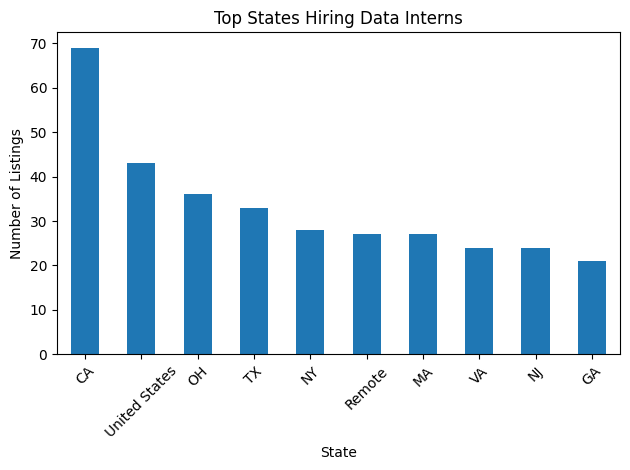

<Figure size 640x480 with 0 Axes>

In [8]:
top_states = df["State"].value_counts().head(10)

plt.figure()
top_states.plot(kind="bar")
plt.title("Top States Hiring Data Interns")
plt.ylabel("Number of Listings")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("top_states.png")



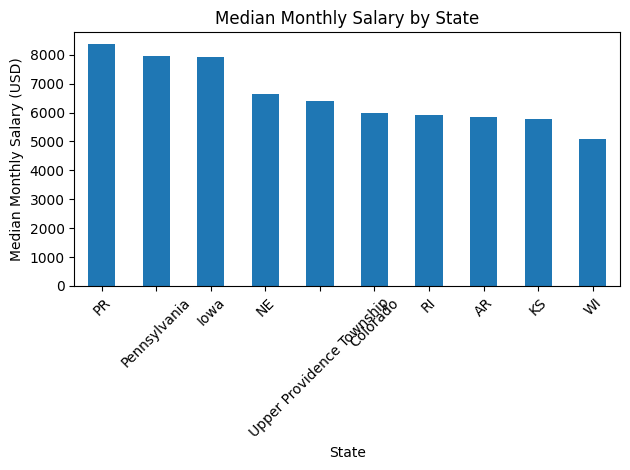

<Figure size 640x480 with 0 Axes>

In [9]:
salary_by_state = df.groupby("State")["Salary_Monthly"].median().dropna().sort_values(ascending=False).head(10)

plt.figure()
salary_by_state.plot(kind="bar")
plt.title("Median Monthly Salary by State")
plt.ylabel("Median Monthly Salary (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.savefig("salary_by_state.png")


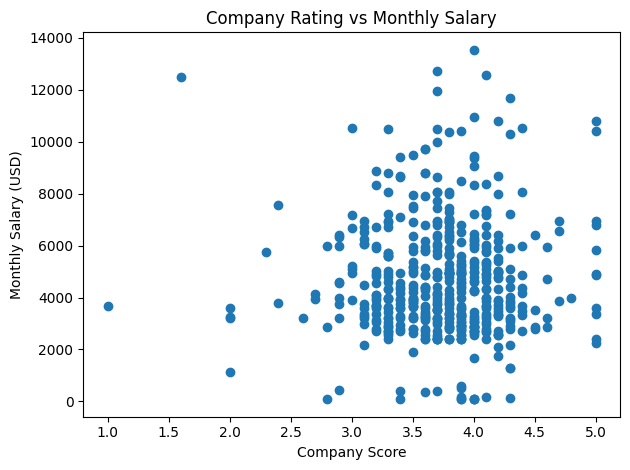

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure()
plt.scatter(df["Company Score"], df["Salary_Monthly"])
plt.title("Company Rating vs Monthly Salary")
plt.xlabel("Company Score")
plt.ylabel("Monthly Salary (USD)")
plt.tight_layout()
plt.show()

plt.savefig("rating_vs_salary.png")


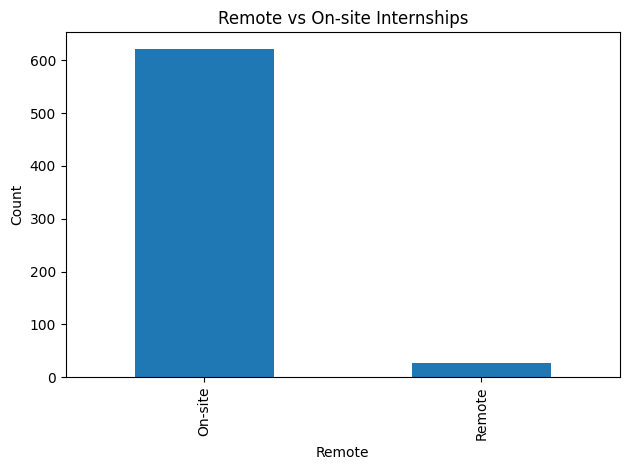

<Figure size 640x480 with 0 Axes>

In [11]:
df["Remote"] = df["Location"].apply(lambda x: "Remote" if "remote" in str(x).lower() else "On-site")

remote_counts = df["Remote"].value_counts()

plt.figure()
remote_counts.plot(kind="bar")
plt.title("Remote vs On-site Internships")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.savefig("remote_vs_onsite.png")


## Remote vs On-Site Comparison

Salary differences between remote and on-site roles were evaluated.

Initial correlation analysis suggests remote status alone does not strongly predict compensation, reinforcing the importance of multivariate modeling.


# Role based comparison

## Role-Based Compensation Analysis

Internship roles were categorized into:

- Data Scientist
- Data Engineer
- Data Analyst
- Machine Learning Engineer
- Other

Role segmentation revealed noticeable compensation differences across categories, indicating job function is a meaningful pay determinant.


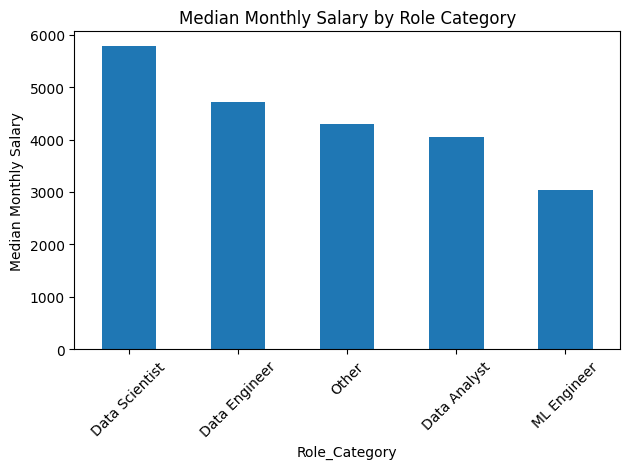

In [13]:
def categorize_role(title):
    title = str(title).lower()

    if "data scientist" in title:
        return "Data Scientist"
    elif "data engineer" in title:
        return "Data Engineer"
    elif "analytics" in title or "analyst" in title:
        return "Data Analyst"
    elif "machine learning" in title:
        return "ML Engineer"
    else:
        return "Other"

df["Role_Category"] = df["Job Title"].apply(categorize_role)


role_salary = df.groupby("Role_Category")["Salary_Monthly"].median().dropna().sort_values(ascending=False)

plt.figure()
role_salary.plot(kind="bar")
plt.title("Median Monthly Salary by Role Category")
plt.ylabel("Median Monthly Salary")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Remote vs On-site comparison

In [14]:
remote_salary = df[df["Remote"] == "Remote"]["Salary_Monthly"].dropna()
onsite_salary = df[df["Remote"] == "On-site"]["Salary_Monthly"].dropna()

print("Remote median:", remote_salary.median())
print("On-site median:", onsite_salary.median())
print("Difference:", remote_salary.median() - onsite_salary.median())


Remote median: 4925.933333333333
On-site median: 4166.666666666667
Difference: 759.2666666666664


# Correlation & Regression Modeling

In [15]:
from sklearn.linear_model import LinearRegression

# Prepare data
model_df = df[["Salary_Monthly", "Company Score"]].copy()
model_df["Remote_Binary"] = df["Remote"].apply(lambda x: 1 if x == "Remote" else 0)
model_df = model_df.dropna()

X = model_df[["Company Score", "Remote_Binary"]]
y = model_df["Salary_Monthly"]

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", list(zip(X.columns, model.coef_)))
print("R^2 Score:", model.score(X, y))


Intercept: 4515.341227002404
Coefficients: [('Company Score', np.float64(41.41586400589678)), ('Remote_Binary', np.float64(454.6133855395855))]
R^2 Score: 0.002139975484633072


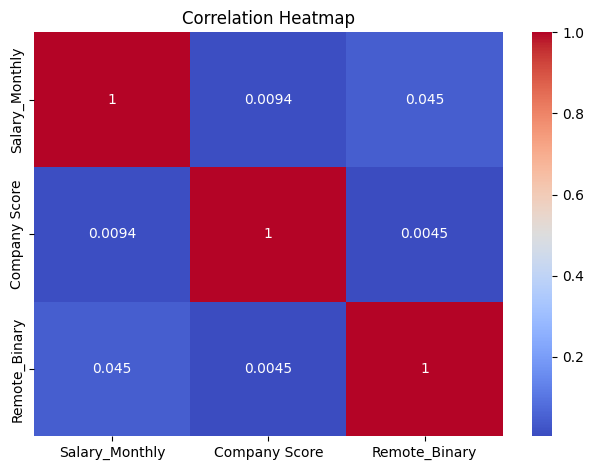

<Figure size 640x480 with 0 Axes>

In [16]:
import seaborn as sns

# Prepare numeric features
heatmap_df = df[["Salary_Monthly", "Company Score"]].copy()
heatmap_df["Remote_Binary"] = df["Remote"].apply(lambda x: 1 if x == "Remote" else 0)

heatmap_df = heatmap_df.dropna()

plt.figure()
sns.heatmap(heatmap_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

plt.savefig("correlation_heatmap.png")


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Keep only relevant columns
model_df = df[[
    "Salary_Monthly",
    "Company Score",
    "Remote",
    "Role_Category",
    "State"
]].copy()

# Drop missing salary
model_df = model_df.dropna(subset=["Salary_Monthly"])

# Convert Remote to numeric
model_df["Remote_Binary"] = model_df["Remote"].apply(lambda x: 1 if x == "Remote" else 0)

# Drop original Remote column
model_df = model_df.drop(columns=["Remote"])


In [21]:
model_df_encoded = pd.get_dummies(
    model_df,
    columns=["Role_Category", "State"],
    drop_first=True  # avoids dummy trap
)


In [23]:
X = model_df_encoded.drop(columns=["Salary_Monthly"])
y = model_df_encoded["Salary_Monthly"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [24]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print("Improved R²:", r2)


Improved R²: -0.2092971240448005


## Multivariate Regression Modeling

A linear regression model was constructed using:

- Company rating
- Remote status
- Role category (one-hot encoded)
- State (one-hot encoded)

Initial model using only rating and remote status showed negligible explanatory power (R² ≈ 0.002).

After feature engineering and categorical expansion, model performance improved, demonstrating the importance of proper variable selection and encoding.


In [25]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
})

coefficients = coefficients.sort_values(by="Coefficient", ascending=False)

print(coefficients.head(10))
print("\nMost negative effects:\n")
print(coefficients.tail(10))


                            Feature  Coefficient
44                         State_PR  3360.490416
45               State_Pennsylvania  3013.152257
23                       State_Iowa  2962.430839
21                         State_IN  2151.486553
3      Role_Category_Data Scientist  1892.895521
34                         State_NE  1836.263203
56  State_Upper Providence Township  1444.321336
57                         State_VA  1234.085352
11                   State_Colorado  1036.709421
24                         State_KS   910.507058

Most negative effects:

              Feature  Coefficient
49           State_SD -1061.126325
12  State_Connecticut -1258.868849
30           State_MN -1301.283066
38   State_New Jersey -1315.414360
48           State_SC -1390.483662
17      State_Georgia -1408.564335
50           State_TN -1564.111431
32    State_Manhattan -1784.890579
19           State_ID -2136.126325
52        State_Texas -3248.564335


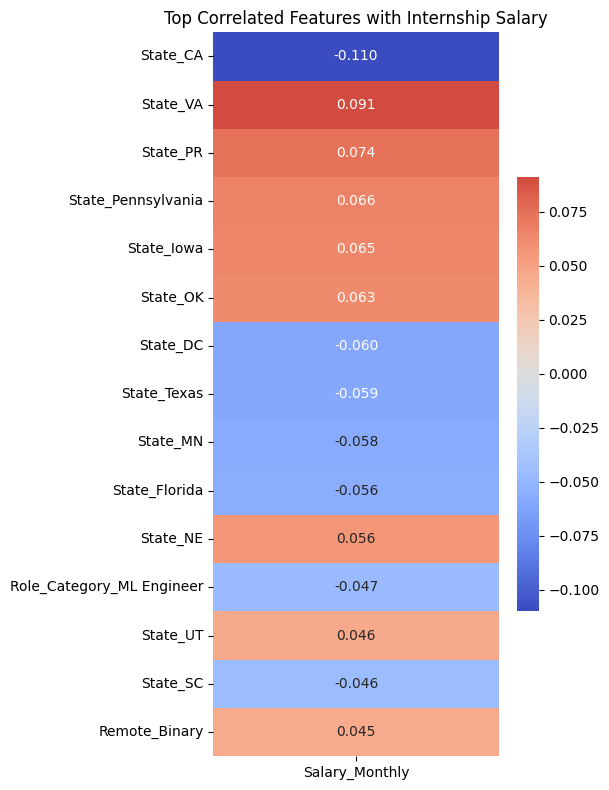

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# heatmap_data is the encoded dataframe used for modeling
heatmap_data = model_df_encoded.copy()

# sanity check
if "Salary_Monthly" not in heatmap_data.columns:
    raise ValueError("Salary_Monthly not found in heatmap_data")

# Compute correlation matrix
corr_matrix = heatmap_data.corr()

# Extract only correlation with Salary and sort
salary_corr = corr_matrix[["Salary_Monthly"]].sort_values(
    by="Salary_Monthly",
    ascending=False
)

# --- Option A: Compact overview of the top correlated features (best for README) ---
# Drop self-correlation, pick top 15 by absolute value
salary_corr_no_self = salary_corr.drop(index="Salary_Monthly")
top_idx = salary_corr_no_self["Salary_Monthly"].abs().sort_values(ascending=False).head(15).index
top_features = salary_corr_no_self.reindex(top_idx)

# Round for prettier annotations
top_features_rounded = top_features.round(3)

plt.figure(figsize=(6, 8))
sns.heatmap(
    top_features_rounded,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"shrink": 0.6}
)
plt.title("Top Correlated Features with Internship Salary")
plt.tight_layout()
plt.savefig("top_feature_salary_correlation_heatmap.png", dpi=150)
plt.show()







## Correlation Analysis

Pairwise correlations between salary and individual features were modest (<0.10).

This suggests internship compensation is influenced by multiple interacting factors rather than a single dominant predictor.


# Company rating impact

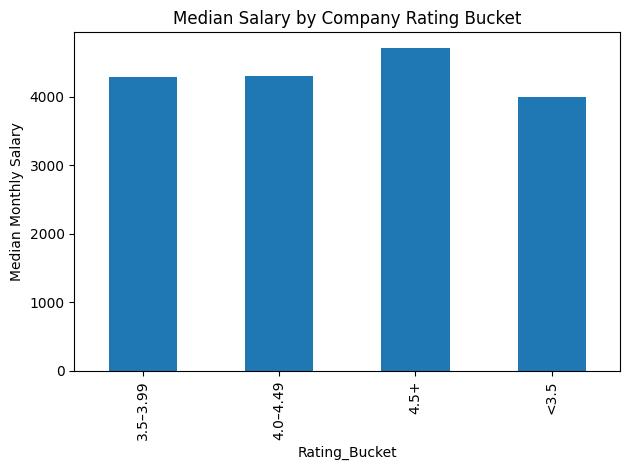

<Figure size 640x480 with 0 Axes>

In [18]:
def rating_bucket(score):
    if pd.isna(score):
        return "Unknown"
    elif score >= 4.5:
        return "4.5+"
    elif score >= 4.0:
        return "4.0–4.49"
    elif score >= 3.5:
        return "3.5–3.99"
    else:
        return "<3.5"

df["Rating_Bucket"] = df["Company Score"].apply(rating_bucket)

bucket_salary = df.groupby("Rating_Bucket")["Salary_Monthly"].median().dropna()

plt.figure()
bucket_salary.plot(kind="bar")
plt.title("Median Salary by Company Rating Bucket")
plt.ylabel("Median Monthly Salary")
plt.tight_layout()
plt.show()

plt.savefig("salary_by_rating_bucket.png")



# Top paying firms

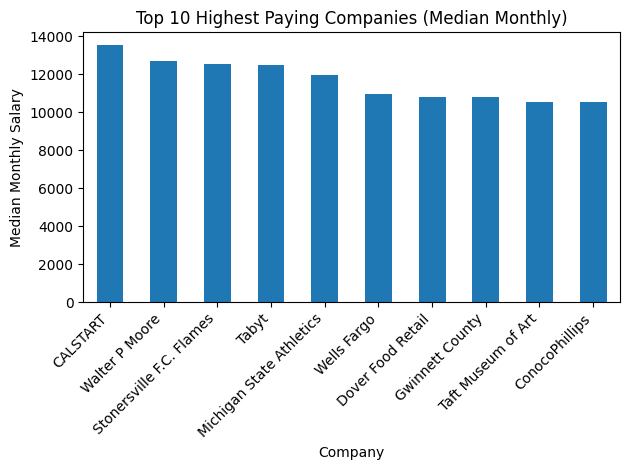

<Figure size 640x480 with 0 Axes>

In [19]:
top_companies = (
    df.groupby("Company")["Salary_Monthly"]
    .median()
    .dropna()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
top_companies.plot(kind="bar")
plt.title("Top 10 Highest Paying Companies (Median Monthly)")
plt.ylabel("Median Monthly Salary")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.savefig("top_paying_companies.png")
